In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import re
from pathlib import Path

In [2]:
# # Path to ablation results
results_dir = Path("../precomputed/gpt_4o_mini/ablation_results")

# --- File config ---
csv_files = sorted([
    f for f in results_dir.glob("nested_cv_llm__anonymised*.csv")
    if "chronological" not in f.name.lower()
])

# --- Labels of interest ---
target_labels_map = {
    "F0_5": "Optimise $F_{0.5}$",
    "F1": "Optimise $F_{1}$",
    "F2": "Optimise $F_{2}$",
    "PRECISION": "Optimise Precision",
}

# --- Compute F-score ---
def f_beta_score(tp, fp, fn, beta=0.5):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if precision + recall == 0:
        return 0.0
    beta_sq = beta ** 2
    return (1 + beta_sq) * (precision * recall) / (beta_sq * precision + recall)

def compute_pooled_metrics(df):
    grouped = df.groupby("Repeat")
    total_tp = sum(group["TP"].sum() for _, group in grouped)
    total_fp = sum(group["FP"].sum() for _, group in grouped)
    total_fn = sum(group["FN"].sum() for _, group in grouped)
    return {
        "Precision": round(total_tp / (total_tp + total_fp), 4) if total_tp + total_fp > 0 else 0.0,
        "Recall": round(total_tp / (total_tp + total_fn), 4) if total_tp + total_fn > 0 else 0.0,
        "F0.5": round(f_beta_score(total_tp, total_fp, total_fn, beta=0.5), 4),
        "F1": round(f_beta_score(total_tp, total_fp, total_fn, beta=1.0), 4),
        "F2": round(f_beta_score(total_tp, total_fp, total_fn, beta=2.0), 4),
    }

def compute_avg_metrics(metrics_list):
    precisions, recalls, f05s = [], [], []
    for m in metrics_list:
        tp, fp, fn = m["TP"], m["FP"], m["FN"]
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f05 = (1.25 * prec * rec / (0.25 * prec + rec)) if (prec + rec) > 0 else 0.0
        precisions.append(prec)
        recalls.append(rec)
        f05s.append(f05)
    return {
        "Precision": round(np.mean(precisions), 4),
        "Recall": round(np.mean(recalls), 4),
        "F0.5": round(np.mean(f05s), 4)
    }

In [3]:
metric_table = []
for file in csv_files:
    stem = file.stem
    if not (
        "similarity_hamming_0_15" in stem and
        "sortbyf0_5" in stem and
        "__expert" not in stem and
        "__expert_only" not in stem and
        "cluster" not in stem
    ):
        continue  # skip files that don’t exactly match

    df = pd.read_csv(file)
    if not all(col in df.columns for col in ["Repeat", "TP", "FP", "FN"]):
        continue

    match = re.search(r"optimise([A-Z0-9_]+)_sortby", stem)
    if not match:
        continue

    opt_key = match.group(1)
    if opt_key in target_labels_map:
        label = target_labels_map[opt_key]

        # Create list of per-repeat metrics
        grouped = df.groupby("Repeat")
        repeat_metrics = []
        for _, g in grouped:
            repeat_metrics.append({
                "TP": g["TP"].sum(),
                "FP": g["FP"].sum(),
                "FN": g["FN"].sum(),
            })

        metrics = compute_avg_metrics(repeat_metrics)
        metric_table.append({"Optimisation Target": label, **metrics})


In [4]:
# --- Load vanilla results with precomputed metrics ---
vanilla_dir = Path("../precomputed/gpt_4o_mini/vanilla")

vanilla_files = {
    "Zero-shot GPT-4o": "vanilla_zero_shot_gpt_4o_mini_anonymised_rep_1.csv",
    "Zero-shot o3": "vanilla_zero_shot_o3_anonymised_rep_1.csv",
    "Zero-shot o3-mini": "vanilla_zero_shot_o3_mini_anonymised_rep_1.csv",
    "Few-shot GPT-4o": "vanilla_few_shot_gpt_4o_mini_anonymised_rep_1.csv",
    "Few-shot o3": "vanilla_few_shot_o3_anonymised_rep_1.csv",
    "Few-shot o3-mini": "vanilla_few_shot_o3_mini_anonymised_rep_1.csv",
}

vanilla_metrics = {}
for label, fname in vanilla_files.items():
    df = pd.read_csv(vanilla_dir / fname)
    if all(c in df.columns for c in ["Prec", "Rec", "F0.5"]):
        vanilla_metrics[label] = {
            "Precision": round(df["Prec"].iloc[3], 3),
            "Recall": round(df["Rec"].iloc[3], 3),
            "F0.5": round(df["F0.5"].iloc[3], 3),
        }
    else:
        print(f"⚠️ Skipping {fname} — missing Prec/Rec/F0.5 columns")

vanilla_table = pd.DataFrame(vanilla_metrics).T

# --- RRF row from preloaded metric_table ---
rrf_f05_label = "Optimise $F_{0.5}$"
cols_to_show = ["Precision", "Recall", "F0.5"]

if not isinstance(metric_table, pd.DataFrame):
    metric_table = pd.DataFrame(metric_table).set_index("Optimisation Target")


# Then select RRF row
rrf_f05_row = metric_table.loc[[rrf_f05_label], cols_to_show].round(3)

# --- Combine all ---
combined_table = pd.concat([rrf_f05_row, vanilla_table], axis=0)

# --- Custom order and renaming ---
custom_labels = {
    rrf_f05_label: ("RRF", "LLM + Ensemble"),
    "Few-shot o3": ("o3", "Few Shot"),
    "Zero-shot GPT-4o": ("GPT-4o-mini", "Zero Shot"),
    "Few-shot GPT-4o": ("GPT-4o-mini", "Few Shot"),
    "Zero-shot o3-mini": ("o3-mini", "Zero Shot"),
    "Zero-shot o3": ("o3", "Zero Shot"),
    "Few-shot o3-mini": ("o3-mini", "Few Shot"),
}

# Reorder
final_table = combined_table#.reindex(custom_labels.keys())

final_table = final_table.sort_values("F0.5", ascending=False)


# Add model + approach columns
final_table.insert(0, "Model", [custom_labels[i][0] for i in final_table.index])
final_table.insert(1, "Approach", [custom_labels[i][1] for i in final_table.index])

# Bold max values
def bold_max(df, column):
    max_val = df[column].max()
    return df[column].apply(lambda x: f"**{x:.3f}**" if x == max_val else f"{x:.3f}")

styled_table = final_table.copy()
for col in ["Precision", "Recall", "F0.5"]:
    styled_table[col] = bold_max(final_table, col)

# --- Print to markdown for LaTeX/table rendering or export ---
print("\n📊 Final Table (Markdown-style for LaTeX):\n")
print(styled_table.to_markdown(index=False))



📊 Final Table (Markdown-style for LaTeX):

| Model       | Approach       | Precision   | Recall    | F0.5      |
|:------------|:---------------|:------------|:----------|:----------|
| RRF         | LLM + Ensemble | **0.131**   | 0.101     | **0.124** |
| o3          | Few Shot       | 0.077       | 0.196     | 0.088     |
| GPT-4o-mini | Zero Shot      | 0.079       | 0.139     | 0.086     |
| o3-mini     | Zero Shot      | 0.070       | 0.177     | 0.080     |
| GPT-4o-mini | Few Shot       | 0.065       | **0.316** | 0.077     |
| o3          | Zero Shot      | 0.083       | 0.036     | 0.066     |
| o3-mini     | Few Shot       | 0.038       | 0.286     | 0.047     |


In [5]:
# Helper function
def extract_metrics_from_file(file):
    df = pd.read_csv(file)
    grouped = df.groupby("Repeat")
    metrics = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})
    for name, group in grouped:
        metrics[name]["TP"] += group["TP"].sum()
        metrics[name]["FP"] += group["FP"].sum()
        metrics[name]["FN"] += group["FN"].sum()
    return list(metrics.values())

file_llm = f"{results_dir}/nested_cv_llm__anonymisedsimilarity_hamming_0_15_optimiseF0_5_sortbyf0_5.csv"
file_llm_exp = f"{results_dir}/nested_cv_llm_expert__anonymisedsimilarity_hamming_0_01_optimiseF0_5_sortbyf0_5.csv"
# file_exp = "nested_cv_expert_only__anonymisedsimilarity_cosine-cluster_0_85_optimiseF0_5_sortbyf0_5.csv"
file_exp = f"{results_dir}/nested_cv_expert_only__anonymisedsimilarity_cosine-cluster_0_85_optimiseF0_5_sortbyf0_5_exp1.csv"


llm_metrics = compute_avg_metrics(extract_metrics_from_file(file_llm))
llm_exp_metrics = compute_avg_metrics(extract_metrics_from_file(file_llm_exp))
exp_metrics = compute_avg_metrics(extract_metrics_from_file(file_exp))

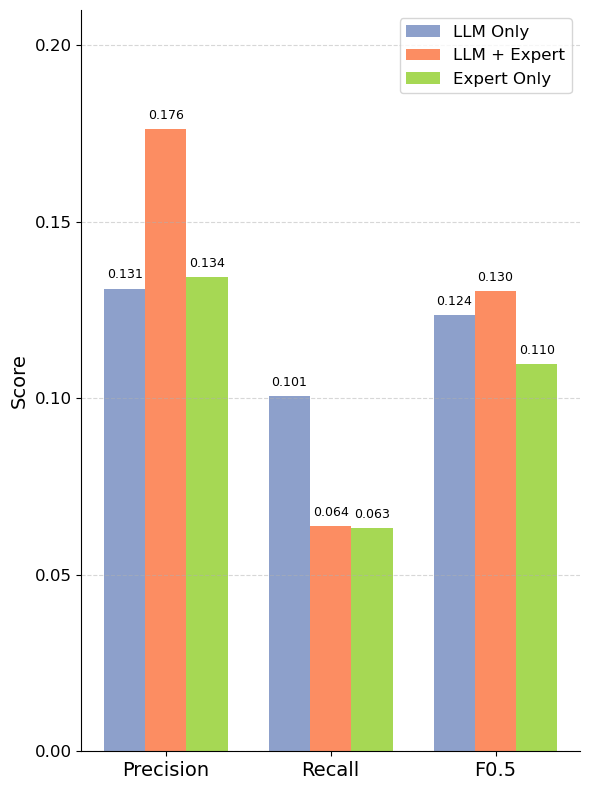

In [6]:
from decimal import Decimal, ROUND_HALF_UP

def round_half_up(value, ndigits):
    q = Decimal("1." + "0" * ndigits)
    return float(Decimal(str(value)).quantize(q, rounding=ROUND_HALF_UP))

# --- Plot grouped bar chart ---
metric_names = ["Precision", "Recall", "F0.5"]
x = np.arange(len(metric_names))
width = 0.25

fig, ax = plt.subplots(figsize=(6, 8))
colors = ["#8da0cb", "#fc8d62", "#a6d854"]

# Prepare values
llm_vals = [llm_metrics["Precision"], llm_metrics["Recall"], llm_metrics["F0.5"]]
llm_exp_vals = [llm_exp_metrics["Precision"], llm_exp_metrics["Recall"], llm_exp_metrics["F0.5"]]
exp_vals = [exp_metrics["Precision"], exp_metrics["Recall"], exp_metrics["F0.5"]]

# Plot bars
bars1 = ax.bar(x - width, llm_vals, width, label="LLM Only", color=colors[0])
bars2 = ax.bar(x, llm_exp_vals, width, label="LLM + Expert", color=colors[1])
bars3 = ax.bar(x + width, exp_vals, width, label="Expert Only", color=colors[2])

for bar_group in [bars1, bars2, bars3]:
    for bar in bar_group:
        height = bar.get_height()
        rounded = round_half_up(height, 3)
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.002,
            f"{rounded:.3f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

# Formatting
ax.set_ylabel("Score", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=14)
ax.set_yticks([0.0, 0.05, 0.1, 0.15, 0.20])
ax.set_ylim(0, 0.21)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
# Load all files from ablation_results
csv_files = sorted(results_dir.glob("*.csv"))

labels, mean_data, pooled_data = [], [], []

for file in csv_files:
    df = pd.read_csv(file)
    
    if not all(col in df.columns for col in ["F05_Outer", "Repeat", "TP", "FP", "FN"]):
        continue

    filename = file.stem.lower()
    
    # Infer mode
    if filename.startswith("nested_cv_llm__anonymised"):
        source = "LLM-Only"
    elif filename.startswith("nested_cv_llm_expert__anonymised"):
        source = "LLM+Expert"
    elif filename.startswith("nested_cv_expert_only__anonymised"):
        source = "Expert Only"
    else:
        continue

    # Extract similarity metric, threshold, optimise, sort
    match = re.search(
        r"similarity_(\w+)-?(\w+)?_(\d+)_(\d+)_optimise([a-zA-Z0-9_]+)_sortby([a-zA-Z0-9_]+)", 
        filename
    )
    if not match:
        continue

    sim_metric = match.group(1)
    if match.group(2):  # e.g. cosine-cluster
        sim_metric += "-" + match.group(2)
    sim_thresh = float(f"{match.group(3)}.{match.group(4)}")
    optimise_for = match.group(5).replace("_", ".")
    sort_by = match.group(6).replace("_", ".")

    # Use parsed info to generate label
    label = f"{source}\n{sim_metric}, sim={sim_thresh}; optimise={optimise_for}; sortby={sort_by}"

    grouped = df.groupby("Repeat")
    mean_f05 = grouped["F05_Outer"].mean().values
    pooled_f05 = [
        f_beta_score(g["TP"].sum(), g["FP"].sum(), g["FN"].sum(), beta=0.5)
        for _, g in grouped
    ]
    if len(mean_f05) > 0 and len(pooled_f05) > 0:
        labels.append(label)
        mean_data.append(mean_f05)
        pooled_data.append(pooled_f05)

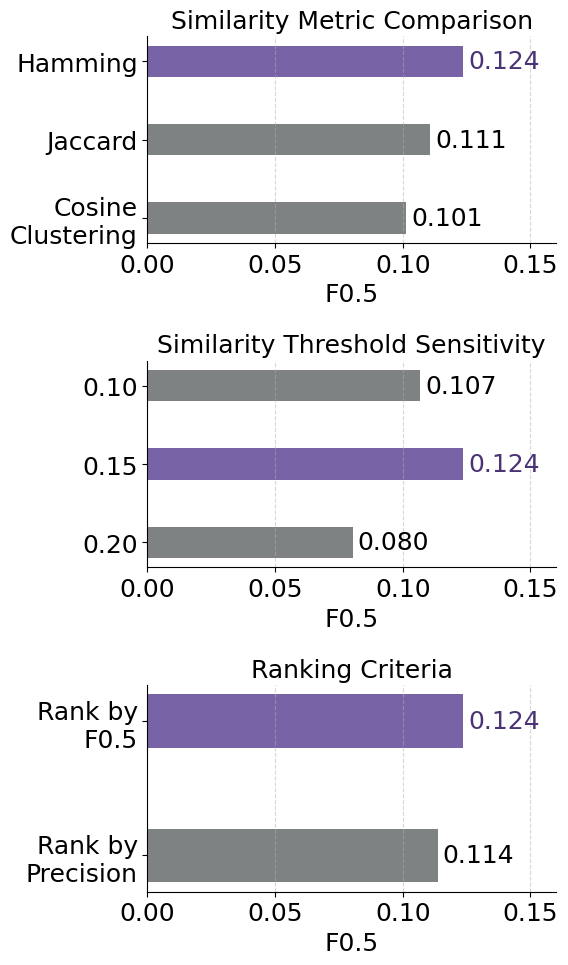

In [8]:
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
})

n_reps = 10
highlight_label = f"LLM-Only\nhamming, sim=0.15; optimise=f0.5; sortby=f0.5"
highlight_color = "#7863a6"
default_color = "#7f8283"

# Comparison groups
comparison_groups = [
    ("Similarity Metric Comparison", [
        ("LLM-Only\nhamming, sim=0.15; optimise=f0.5; sortby=f0.5", "Hamming"),
        ("LLM-Only\njaccard, sim=0.9; optimise=f0.5; sortby=f0.5", "Jaccard"),
        ("LLM-Only\ncosine-cluster, sim=0.85; optimise=f0.5; sortby=f0.5", "Cosine\nClustering"),
    ]),
    ("Similarity Threshold Sensitivity", [
        ("LLM-Only\nhamming, sim=0.1; optimise=f0.5; sortby=f0.5", "0.10"),
        ("LLM-Only\nhamming, sim=0.15; optimise=f0.5; sortby=f0.5", "0.15"),
        ("LLM-Only\nhamming, sim=0.2; optimise=f0.5; sortby=f0.5", "0.20"),
    ]),
    ("Ranking Criteria", [
        ("LLM-Only\nhamming, sim=0.15; optimise=f0.5; sortby=f0.5", "Rank by\nF0.5"),
        ("LLM-Only\nhamming, sim=0.15; optimise=f0.5; sortby=precision", "Rank by\nPrecision"),
    ]),
]

# Assume labels and pooled_data exist
pooled_means = {
    label: np.mean(scores)
    for label, scores in zip(labels, pooled_data)
}

# Plot setup
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
axes = axes.flatten()

for ax, (title, label_pairs) in zip(axes, comparison_groups):
    # Skip sorting for the second group only
    if title != "Similarity Threshold Sensitivity":
        label_pairs = sorted(label_pairs, key=lambda x: pooled_means.get(x[0], 0), reverse=True)

    raw_labels = [raw for raw, _ in label_pairs]
    display_labels = [disp for _, disp in label_pairs]
    means = [pooled_means.get(raw, 0) for raw in raw_labels]
    colors = [highlight_color if raw == highlight_label else default_color for raw in raw_labels]

    bars = ax.barh(display_labels, means, color=colors, height=0.4)
    ax.set_xlim(0, 0.16)
    ax.set_xticks([0.00, 0.05, 0.10, 0.15])
    ax.set_xlabel("F0.5")
    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    for bar, score, raw_label in zip(bars, means, raw_labels):
        text_color = "#4b3474" if raw_label == highlight_label else "black"
        ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2,
                f"{score:.3f}", va='center', ha='left', fontsize=18, color=text_color)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

fig.tight_layout()
plt.show()


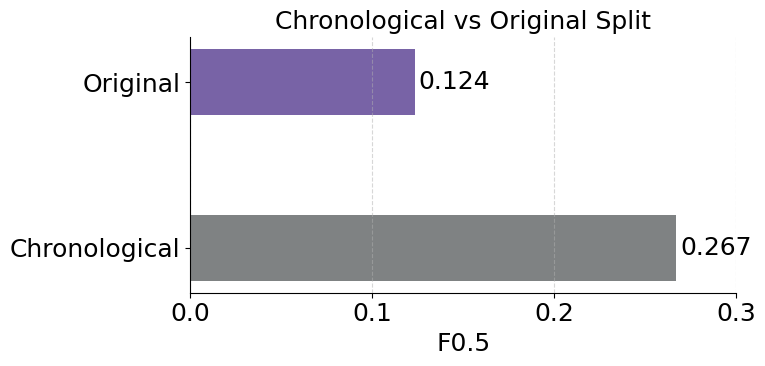

In [9]:
# Define paths
file_llm = results_dir / "nested_cv_llm__anonymisedsimilarity_hamming_0_15_optimiseF0_5_sortbyf0_5.csv"
file_chron = results_dir / "nested_cv_llm__anonymisedsimilarity_hamming_0_15_optimiseF0_5_sortbyf0_5_chronological.csv"

# Load both
df_llm = pd.read_csv(file_llm)
df_chron = pd.read_csv(file_chron)

# Compute pooled F0.5 per repeat
group_llm = df_llm.groupby("Repeat")
group_chron = df_chron.groupby("Repeat")

scores_llm = [
    f_beta_score(g["TP"].sum(), g["FP"].sum(), g["FN"].sum(), beta=0.5)
    for _, g in group_llm
]

scores_chron = [
    f_beta_score(g["TP"].sum(), g["FP"].sum(), g["FN"].sum(), beta=0.5)
    for _, g in group_chron
]

# Plotting
labels = ["Original", "Chronological"]
data = [np.mean(scores_llm), np.mean(scores_chron)]

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
})

fig, ax = plt.subplots(figsize=(8, 4))
colors = ["#7863a6", "#7f8283"]

bars = ax.barh(labels, data, color=colors, height=0.4)
ax.set_xlim(0, 0.3)
ax.set_xticks([0.00, 0.10, 0.20, 0.30])
ax.set_xlabel("F0.5")
ax.set_title("Chronological vs Original Split")
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.5)

for bar, score in zip(bars, data):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2,
            f"{score:.3f}", va='center', ha='left', fontsize=18)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
plt.show()



In [10]:
# --- File config ---
csv_files = sorted([
    f for f in results_dir.glob("nested_cv_llm__anonymised*.csv")
    if "chronological" not in f.name.lower()
])

# --- Labels of interest ---
target_labels_map = {
    "F0_5": "Optimise $F_{0.5}$",
    "F1": "Optimise $F_{1}$",
    "F2": "Optimise $F_{2}$",
    "PRECISION": "Optimise Precision",
}

# --- Collect metrics ---
metric_table = []
for file in csv_files:
    stem = file.stem
    if not (
        "similarity_hamming_0_15" in stem and
        "sortbyf0_5" in stem and
        "__expert" not in stem and
        "__expert_only" not in stem and
        "cluster" not in stem
    ):
        continue  # skip files that don’t exactly match

    df = pd.read_csv(file)
    if not all(col in df.columns for col in ["Repeat", "TP", "FP", "FN"]):
        continue

    match = re.search(r"optimise([A-Z0-9_]+)_sortby", stem)
    if not match:
        continue

    opt_key = match.group(1)
    if opt_key in target_labels_map:
        label = target_labels_map[opt_key]
        metrics = compute_pooled_metrics(df)
        metric_table.append({"Optimisation Target": label, **metrics})


# --- Format as DataFrame ---
df = pd.DataFrame(metric_table)
df = df.set_index("Optimisation Target")

# --- Order rows manually to match screenshot ---
desired_order = [
    "Optimise $F_{0.5}$",
    "Optimise $F_{2}$",
    "Optimise $F_{1}$",
    "Optimise Precision",
]
df = df.loc[desired_order]

# --- Bold max values ---
def bold_max(s):
    return [f"**{v:.4f}**" if v == s.max() else f"{v:.4f}" for v in s]

styled_df = df.apply(bold_max, axis=0)

# --- Print final table in Markdown format ---
print("\n📊 Formatted Table:")
print(styled_df.reset_index().to_markdown(index=False))



📊 Formatted Table:
| Optimisation Target   | Precision   | Recall     | F0.5       | F1         | F2         |
|:----------------------|:------------|:-----------|:-----------|:-----------|:-----------|
| Optimise $F_{0.5}$    | **0.1306**  | 0.1006     | **0.1233** | **0.1137** | 0.1055     |
| Optimise $F_{2}$      | 0.0669      | **0.3146** | 0.0794     | 0.1103     | **0.1807** |
| Optimise $F_{1}$      | 0.0670      | 0.1506     | 0.0754     | 0.0928     | 0.1206     |
| Optimise Precision    | 0.1220      | 0.0291     | 0.0745     | 0.0470     | 0.0343     |
